In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [5]:
import cv2
import imutils

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
import time
from os import listdir

# FUNCTION FOR DATA PREPARATION AND PREPROCESSING

In [8]:
def crop_brain(image, plot = 'False'):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

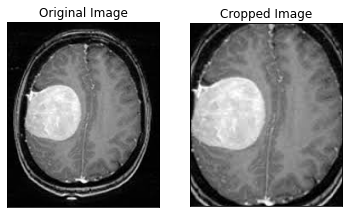

In [9]:
ex_img = cv2.imread(r'./data/brain_tumor_dataset/yes/Y1.jpg')
ex_new_img = crop_brain(ex_img, True)

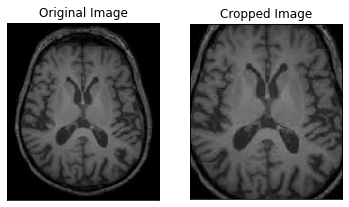

In [10]:
ex_img = cv2.imread(r'./data/brain_tumor_dataset/no/10 no.jpg')
ex_new_img = crop_brain(ex_img, True)

# LOAD DATA

In [11]:
def load_data(dir_list, image_size):
    X = []
    y = []
    image_width, image_height = image_size
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory + '\\' + filename)
            image = crop_brain(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            image = image / 255.
            X.append(image)
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
    X = np.array(X)
    y = np.array(y)
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y


In [12]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2063
X shape is: (2063, 240, 240, 3)
y shape is: (2063, 1)


# PLOT SAMPLE IMAGES

In [13]:
def plot_sample_images(X, y, n=50):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

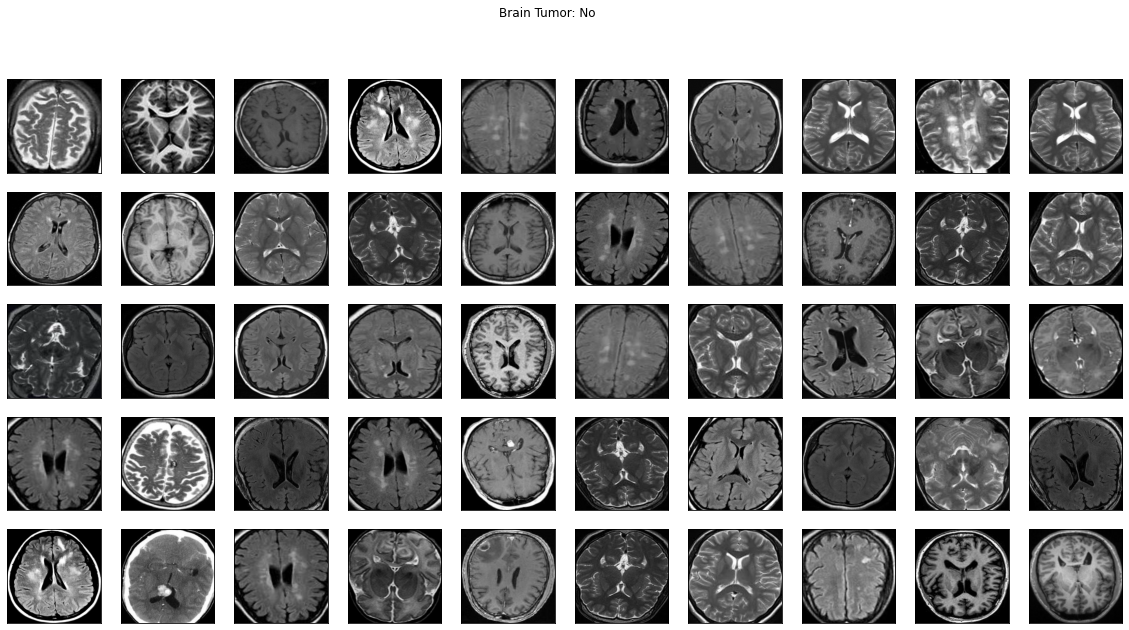

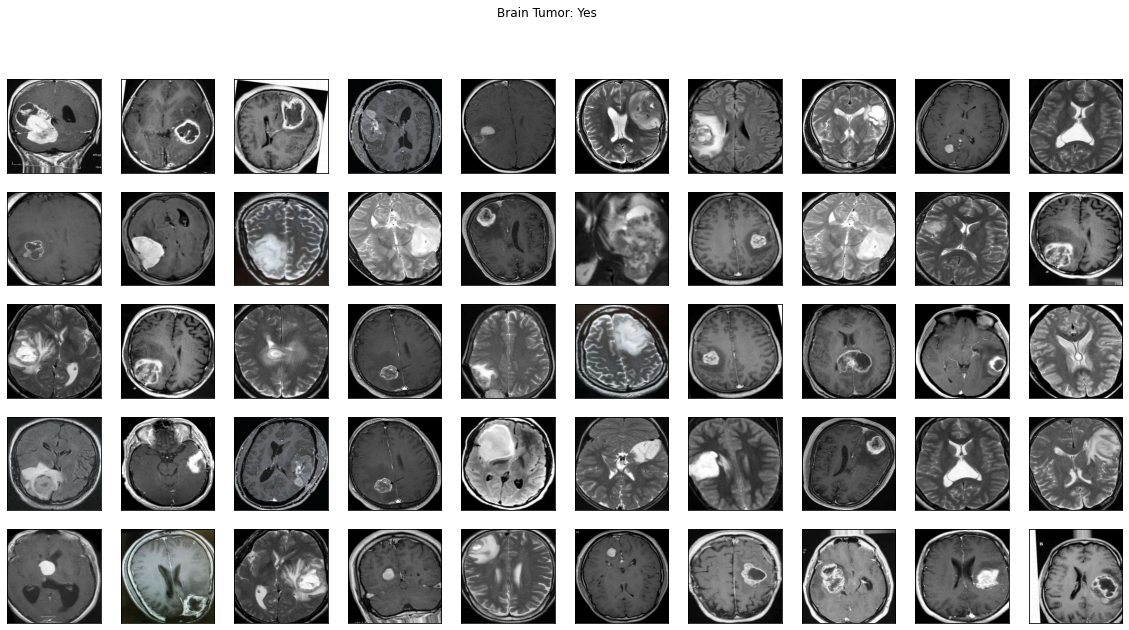

In [14]:
plot_sample_images(X, y)

# SPLIT DATA

In [15]:
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [17]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))


number of training examples = 1444
number of development examples = 310
number of test examples = 309
X_train shape: (1444, 240, 240, 3)
Y_train shape: (1444, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (309, 240, 240, 3)
Y_test shape: (309, 1)


# SOME HELPER FUNCTIONS

In [18]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [19]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# BUILDING THE MODEL
OUR OWN MODEL

In [20]:
def build_model(input_shape):
     # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [21]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_model(IMG_SHAPE)

In [22]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# tensorboard
#log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
#tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [25]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [26]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=12, validation_data=(X_val, y_val), callbacks=[checkpoint])


Epoch 1/12
46/46 [==============================] - 86s 2s/step - loss: 0.7014 - accuracy: 0.6794 - val_loss: 0.6495 - val_accuracy: 0.6452
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.65.model\assets
Epoch 2/12
46/46 [==============================] - 77s 2s/step - loss: 0.4829 - accuracy: 0.7729 - val_loss: 0.6049 - val_accuracy: 0.6806
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.68.model\assets
Epoch 3/12
46/46 [==============================] - 78s 2s/step - loss: 0.4267 - accuracy: 0.7950 - val_loss: 0.5972 - val_accuracy: 0.6774
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.68.model\assets
Epoch 4/12
46/46 [==============================] - 80s 2s/step - loss: 0.3475 - accuracy: 0.8594 - val_loss: 0.5329 - val_accuracy: 0.7677
INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.77.model\assets
Epoch 5/12
46/46 [==============================] - 88s 2s/step - loss: 0.3169 -

In [27]:
history = model.history.history
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [28]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

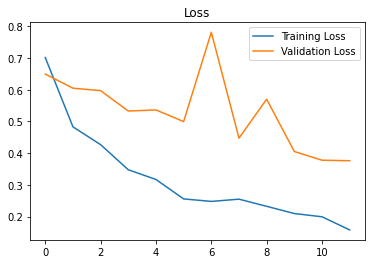

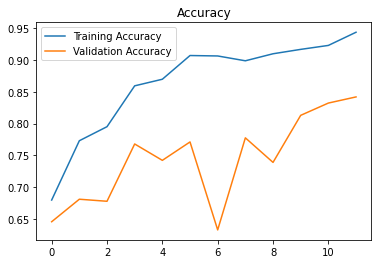

In [29]:
plot_metrics(history) 

In [30]:
best_model = load_model(filepath='models/cnn-parameters-improvement-12-0.84.model')
best_model.metrics_names

['loss', 'accuracy']

In [31]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

       

10/10 [==============================] - 3s 311ms/step - loss: 0.4606 - accuracy: 0.8220


In [32]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.46058979630470276
Test Accuracy = 0.8220064640045166


In [33]:
y_test_prob = best_model.predict(X_test)

In [34]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.8184818481848185


# VGG16


In [37]:
vgg16=tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(240,240,3),pooling=max)

58900480/58889256 [==============================] - 28s 0us/step


In [39]:
from tensorflow.keras.layers import Dropout

In [40]:
VGG16=tf.keras.Sequential()
VGG16.add(vgg16)
VGG16.add(Dropout(0.3))
VGG16.add(Flatten())
VGG16.add(Dropout(0.5))
VGG16.add(Dense(1, activation='sigmoid'))
VGG16.layers[0].trainable = False
VGG16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
VGG16.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [42]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath2="VGG-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint2 = ModelCheckpoint("models/{}.model".format(filepath2, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [44]:
VGG16.fit(x=X_train, y=y_train, batch_size=32, epochs=12, validation_data=(X_val, y_val), callbacks=[checkpoint2])

Epoch 1/12
46/46 [==============================] - 468s 10s/step - loss: 0.6626 - accuracy: 0.6759 - val_loss: 0.3873 - val_accuracy: 0.8387
INFO:tensorflow:Assets written to: models\VGG-01-0.84.model\assets
Epoch 2/12
46/46 [==============================] - 433s 9s/step - loss: 0.3253 - accuracy: 0.8615 - val_loss: 0.2755 - val_accuracy: 0.9129
INFO:tensorflow:Assets written to: models\VGG-02-0.91.model\assets
Epoch 3/12
46/46 [==============================] - 442s 10s/step - loss: 0.2227 - accuracy: 0.9245 - val_loss: 0.2254 - val_accuracy: 0.9258
INFO:tensorflow:Assets written to: models\VGG-03-0.93.model\assets
Epoch 4/12
46/46 [==============================] - 437s 10s/step - loss: 0.2270 - accuracy: 0.9148 - val_loss: 0.1944 - val_accuracy: 0.9419
INFO:tensorflow:Assets written to: models\VGG-04-0.94.model\assets
Epoch 5/12
46/46 [==============================] - 440s 10s/step - loss: 0.1614 - accuracy: 0.9432 - val_loss: 0.1793 - val_accuracy: 0.9323
INFO:tensorflow:Assets 

In [45]:
history1 = VGG16.history.history
for key in history1.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


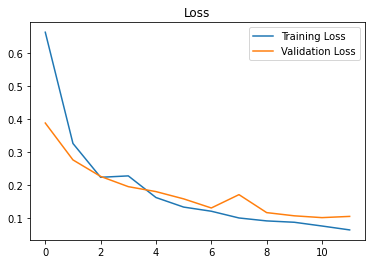

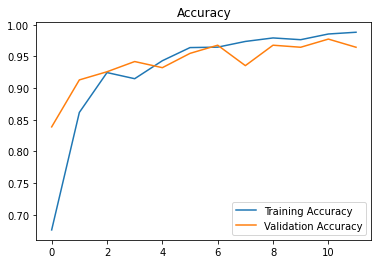

In [46]:
plot_metrics(history1) 

In [52]:
best_model1 = load_model(filepath='models/VGG-11-0.98.model')
best_model1.metrics_names

['loss', 'accuracy']

In [53]:
loss, acc = best_model1.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 79s 8s/step - loss: 0.1292 - accuracy: 0.9515


In [54]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.12921686470508575
Test Accuracy = 0.9514563083648682


In [56]:
y_test_prob1 = best_model1.predict(X_test)

In [57]:
f1score = compute_f1_score(y_test, y_test_prob1)
print(f"F1 score: {f1score}")

F1 score: 0.952076677316294


# ResNet50


In [58]:
resnet50=tf.keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(240,240,3),pooling=max)

94781440/94765736 [==============================] - 45s 0us/step


In [59]:
RESNET50=tf.keras.Sequential()
RESNET50.add(resnet50)
RESNET50.add(Dropout(0.3))
RESNET50.add(Flatten())
RESNET50.add(Dropout(0.5))
RESNET50.add(Dense(1, activation='sigmoid'))
RESNET50.layers[0].trainable = False
RESNET50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [61]:
RESNET50.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 2048)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 131073    
Total params: 23,718,785
Trainable params: 131,073
Non-trainable params: 23,587,712
_________________________________________________________________


In [62]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath3="RES-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint3 = ModelCheckpoint("models/{}.model".format(filepath3, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [63]:
RESNET50.fit(x=X_train, y=y_train, batch_size=32, epochs=12, validation_data=(X_val, y_val), callbacks=[checkpoint3])

Epoch 1/12
46/46 [==============================] - 198s 4s/step - loss: 1.6311 - accuracy: 0.5450 - val_loss: 0.9535 - val_accuracy: 0.5645
INFO:tensorflow:Assets written to: models\RES-01-0.56.model\assets


c:\python\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/12
46/46 [==============================] - 183s 4s/step - loss: 0.8395 - accuracy: 0.6454 - val_loss: 0.7199 - val_accuracy: 0.6581
INFO:tensorflow:Assets written to: models\RES-02-0.66.model\assets


c:\python\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 3/12
46/46 [==============================] - 296s 6s/step - loss: 0.8025 - accuracy: 0.6717 - val_loss: 0.6531 - val_accuracy: 0.6710
INFO:tensorflow:Assets written to: models\RES-03-0.67.model\assets


c:\python\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 4/12
46/46 [==============================] - 313s 7s/step - loss: 0.7656 - accuracy: 0.6953 - val_loss: 1.3797 - val_accuracy: 0.5226
INFO:tensorflow:Assets written to: models\RES-04-0.52.model\assets


c:\python\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 5/12
46/46 [==============================] - 345s 8s/step - loss: 0.9046 - accuracy: 0.6814 - val_loss: 0.5523 - val_accuracy: 0.7097
INFO:tensorflow:Assets written to: models\RES-05-0.71.model\assets


c:\python\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 6/12
46/46 [==============================] - 322s 7s/step - loss: 0.7318 - accuracy: 0.7133 - val_loss: 0.5538 - val_accuracy: 0.7161
INFO:tensorflow:Assets written to: models\RES-06-0.72.model\assets


c:\python\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 7/12
46/46 [==============================] - 329s 7s/step - loss: 0.8002 - accuracy: 0.7237 - val_loss: 0.7943 - val_accuracy: 0.6935
INFO:tensorflow:Assets written to: models\RES-07-0.69.model\assets


c:\python\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 8/12
46/46 [==============================] - 331s 7s/step - loss: 0.8002 - accuracy: 0.7258 - val_loss: 0.5720 - val_accuracy: 0.7194
INFO:tensorflow:Assets written to: models\RES-08-0.72.model\assets


c:\python\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 9/12
46/46 [==============================] - 342s 7s/step - loss: 0.8816 - accuracy: 0.7188 - val_loss: 1.7717 - val_accuracy: 0.5452
INFO:tensorflow:Assets written to: models\RES-09-0.55.model\assets


c:\python\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 10/12
46/46 [==============================] - 319s 7s/step - loss: 0.8331 - accuracy: 0.7361 - val_loss: 0.5495 - val_accuracy: 0.7484
INFO:tensorflow:Assets written to: models\RES-10-0.75.model\assets


c:\python\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 11/12
46/46 [==============================] - 330s 7s/step - loss: 0.6947 - accuracy: 0.7562 - val_loss: 1.9615 - val_accuracy: 0.5742
INFO:tensorflow:Assets written to: models\RES-11-0.57.model\assets


c:\python\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 12/12
46/46 [==============================] - 330s 7s/step - loss: 0.7822 - accuracy: 0.7542 - val_loss: 0.5527 - val_accuracy: 0.7452
INFO:tensorflow:Assets written to: models\RES-12-0.75.model\assets


c:\python\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [64]:
history2 = VGG16.history.history
for key in history2.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


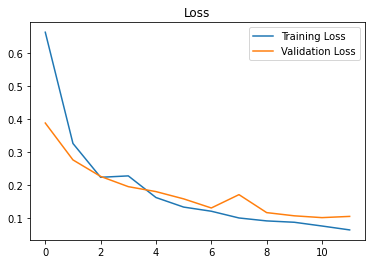

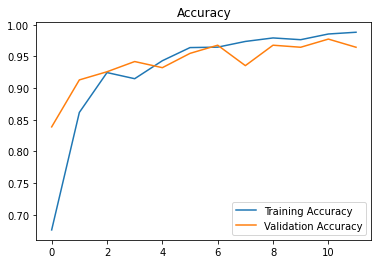

In [65]:
plot_metrics(history2) 

In [67]:
best_model2 = load_model(filepath='models/RES-12-0.75.model')
best_model2.metrics_names

['loss', 'accuracy']

In [68]:
loss, acc = best_model2.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 41s 4s/step - loss: 0.4865 - accuracy: 0.8123


In [69]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.48651400208473206
Test Accuracy = 0.8122977614402771


In [70]:
y_test_prob1 = best_model1.predict(X_test)

In [1]:
f1score = compute_f1_score(y_test, y_test_prob1)
print(f"F1 score: {f1score}")

NameError: name 'compute_f1_score' is not defined